In [2]:
%run Imports.ipynb
from quantpy.tomography.interval import ConfidenceInterval, _pop_hidden_keys, Mode

import numpy as np
import scipy.linalg as la
import scipy.stats as sts
import math

from enum import Enum, auto
from abc import ABC, abstractmethod
from scipy.interpolate import interp1d
from collections import Counter, defaultdict
from functools import partial

from quantpy.geometry import hs_dst, trace_dst, if_dst
from quantpy.qobj import Qobj
from quantpy.routines import (
    _left_inv, _vec2mat, _mat2vec,
    _matrix_to_real_tril_vec, _real_tril_vec_to_matrix,
)

titlesize = 40
labelsize = 40
legendsize = 46
xticksize = 35
yticksize = xticksize
linewidth = 3
fontsize = 55
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize
matplotlib.rcParams['font.size'] = fontsize
matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

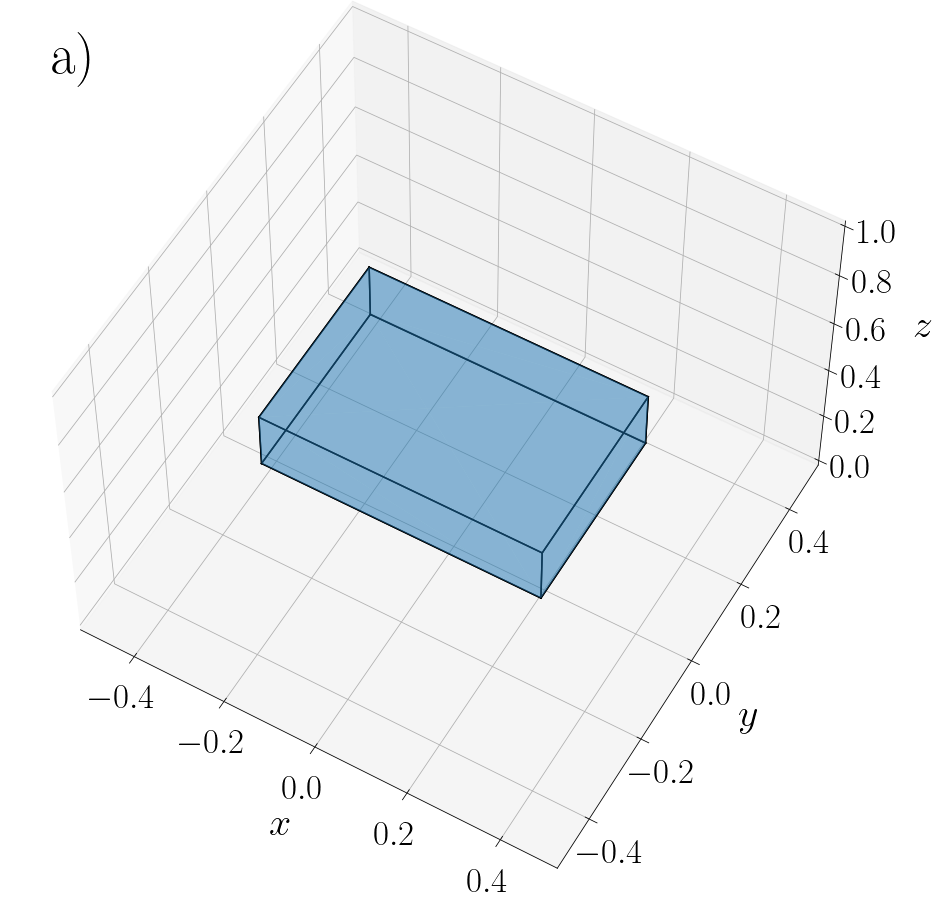

In [3]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull, distance

center = np.asarray([0, 0, 0.5])
diff = np.asarray([0.3, 0.2, 0.1])
vertices_mask = np.asarray([
    [1, 1, 1],
    [1, 1, -1],
    [1, -1, 1],
    [1, -1, -1],
    [-1, 1, 1],
    [-1, 1, -1],
    [-1, -1, 1],
    [-1, -1, -1],
])
cube = vertices_mask * diff[None, :] + center
plane_x = np.asarray([
    [0, 1, 1],
    [0, 1, -1],
    [0, -1, -1],
    [0, -1, 1],
]) / 2 + center
plane_y = np.asarray([
    [1, 0, 1],
    [1, 0, -1],
    [-1, 0, -1],
    [-1, 0, 1],
]) / 2 + center

fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection="3d")
ax.text(-1, 0.2, 0.8, "a)")
hull = ConvexHull(cube)
# draw the polygons of the convex hull
planes = Poly3DCollection([
    plane_x + np.asarray([0.1, 0, 0]), 
    plane_x + np.asarray([-0.1, 0, 0]),
#     plane_y + np.asarray([0, 0.1, 0]), 
#     plane_y + np.asarray([0, -0.1, 0])
])
planes.set_alpha(0.15)
planes.set_color("g")
# ax.add_collection3d(planes)
ax.elev = 55
ax.tick_params(axis='both', which='major', pad=12)
labelpad = 35
ax.set_xlabel('$x$', labelpad=labelpad)
ax.set_ylabel('$y$', labelpad=labelpad)
ax.set_zlabel('$z$', labelpad=labelpad)
for s in hull.simplices:
    tri = Poly3DCollection([cube[s]])
    tri.set_alpha(0.3)
    ax.add_collection3d(tri)
    ax.set_xlim(-.5, .5)
    ax.set_ylim(-.5, .5)
    ax.set_zlim(0, 1)
    edges = []
    if distance.euclidean(cube[s[0]], cube[s[1]]) < distance.euclidean(cube[s[1]], cube[s[2]]):
        edges.append((s[0], s[1]))
        if distance.euclidean(cube[s[1]], cube[s[2]]) < distance.euclidean(cube[s[2]], cube[s[0]]):
            edges.append((s[1], s[2]))
        else:
            edges.append((s[2], s[0]))
    else:
        edges.append((s[1], s[2]))
        if distance.euclidean(cube[s[0]], cube[s[1]]) < distance.euclidean(cube[s[2]], cube[s[0]]):
            edges.append((s[0], s[1]))
        else:
            edges.append((s[2], s[0]))
    for v0, v1 in edges:
        ax.plot(xs=cube[[v0, v1], 0], ys=cube[[v0, v1], 1], zs=cube[[v0, v1], 2], color='black')
# draw the vertices
# ax.scatter(cube[:, 0], cube[:, 1], cube[:, 2], marker='o', color='purple')
# plt.savefig("../imgs/thesis/resize_a.pdf", bbox_inches="tight", pad_inches=0.2)
plt.show()

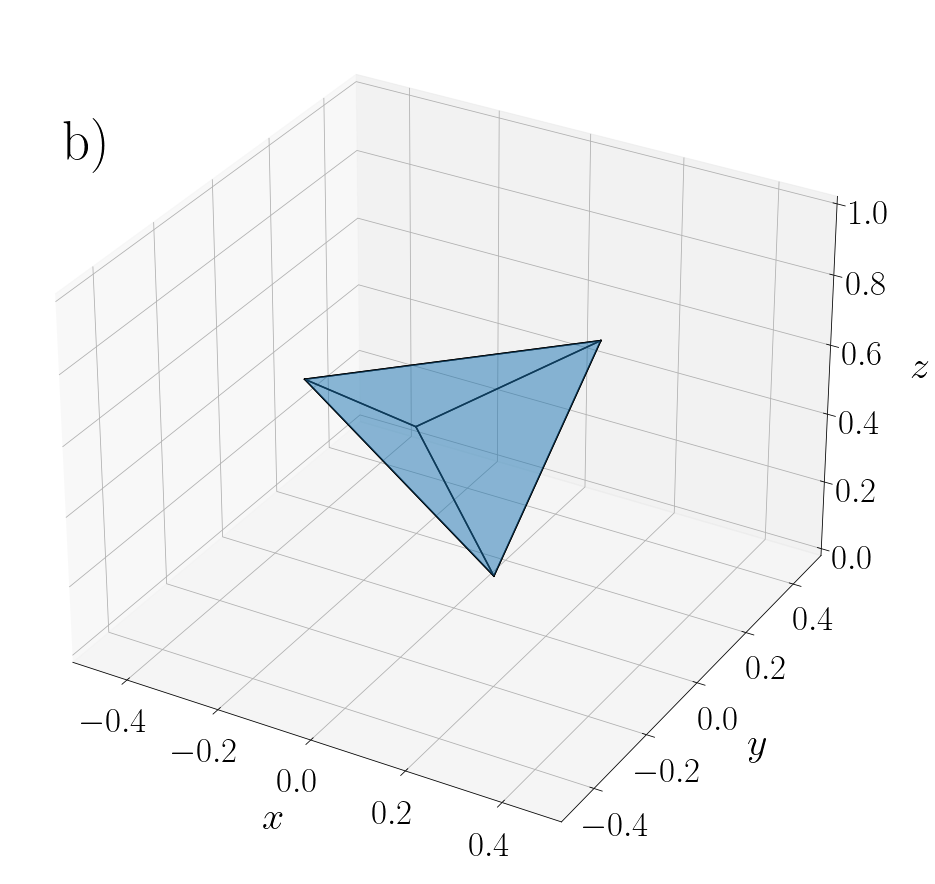

In [4]:
center = np.asarray([0, 0, 0.5])
diff = np.asarray([0.2, 0.2, 0.2])
vertices_mask = np.asarray([
    [1, 1, 1],
    [1, 1, -1],
    [1, -1, 1],
    [1, -1, -1],
    [-1, 1, 1],
    [-1, 1, -1],
    [-1, -1, 1],
    [-1, -1, -1],
])
# cube = vertices_mask * diff[None, :] + center
cube = np.asarray([
    [1, 1, 1],
    [1, -1, -1],
    [-1, 1, -1],
    [-1, -1, 1],
]) / 5 + center

fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection="3d")
ax.text(-1, 0.2, 0.8, "b)")
hull = ConvexHull(cube)
# draw the polygons of the convex hull
ax.tick_params(axis='both', which='major', pad=12)
labelpad = 35
ax.set_xlabel('$x$', labelpad=labelpad)
ax.set_ylabel('$y$', labelpad=labelpad)
ax.set_zlabel('$z$', labelpad=labelpad)
for s in hull.simplices:
    tri = Poly3DCollection([cube[s]])
    tri.set_alpha(0.3)
    ax.add_collection3d(tri)
    ax.set_xlim(-.5, .5)
    ax.set_ylim(-.5, .5)
    ax.set_zlim(0, 1)
    edges = []
#     if distance.euclidean(cube[s[0]], cube[s[1]]) < distance.euclidean(cube[s[1]], cube[s[2]]):
#         edges.append((s[0], s[1]))
#         if distance.euclidean(cube[s[1]], cube[s[2]]) < distance.euclidean(cube[s[2]], cube[s[0]]):
#             edges.append((s[1], s[2]))
#         else:
#             edges.append((s[2], s[0]))
#     else:
#         edges.append((s[1], s[2]))
#         if distance.euclidean(cube[s[0]], cube[s[1]]) < distance.euclidean(cube[s[2]], cube[s[0]]):
#             edges.append((s[0], s[1]))
#         else:
#             edges.append((s[2], s[0]))
    edges.append((s[0], s[1]))
    edges.append((s[2], s[1]))
    edges.append((s[0], s[2]))
    for v0, v1 in edges:
        ax.plot(xs=cube[[v0, v1], 0], ys=cube[[v0, v1], 1], zs=cube[[v0, v1], 2], color='black')
# draw the vertices
# ax.scatter(cube[:, 0], cube[:, 1], cube[:, 2], marker='o', color='purple')
# plt.savefig("../imgs/thesis/polytope_b.pdf", bbox_inches="tight", pad_inches=0.2)
plt.show()